<a href="https://www.kaggle.com/code/rajeshsingh3474/cnn-chest-x-ray?scriptVersionId=151629295" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import pathlib
import PIL
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
train_path = pathlib.Path("../input/chest-xray-pneumonia/chest_xray/train")
val_path = pathlib.Path("../input/chest-xray-pneumonia/chest_xray/val")
test_path = pathlib.Path("../input/chest-xray-pneumonia/chest_xray/test")

In [3]:
image_count = len(list(train_path.glob("*/*.jpeg")))
image_count


5216

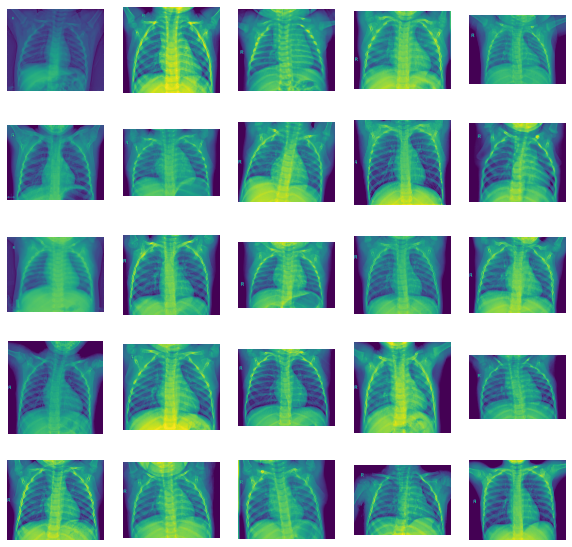

In [4]:
normal_vis = list(train_path.glob("NORMAL/*.jpeg"))
plt.figure(figsize = (10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    img = PIL.Image.open(str(normal_vis[i]))
    plt.imshow(img)
    plt.axis(False)
    
#del normal_vis

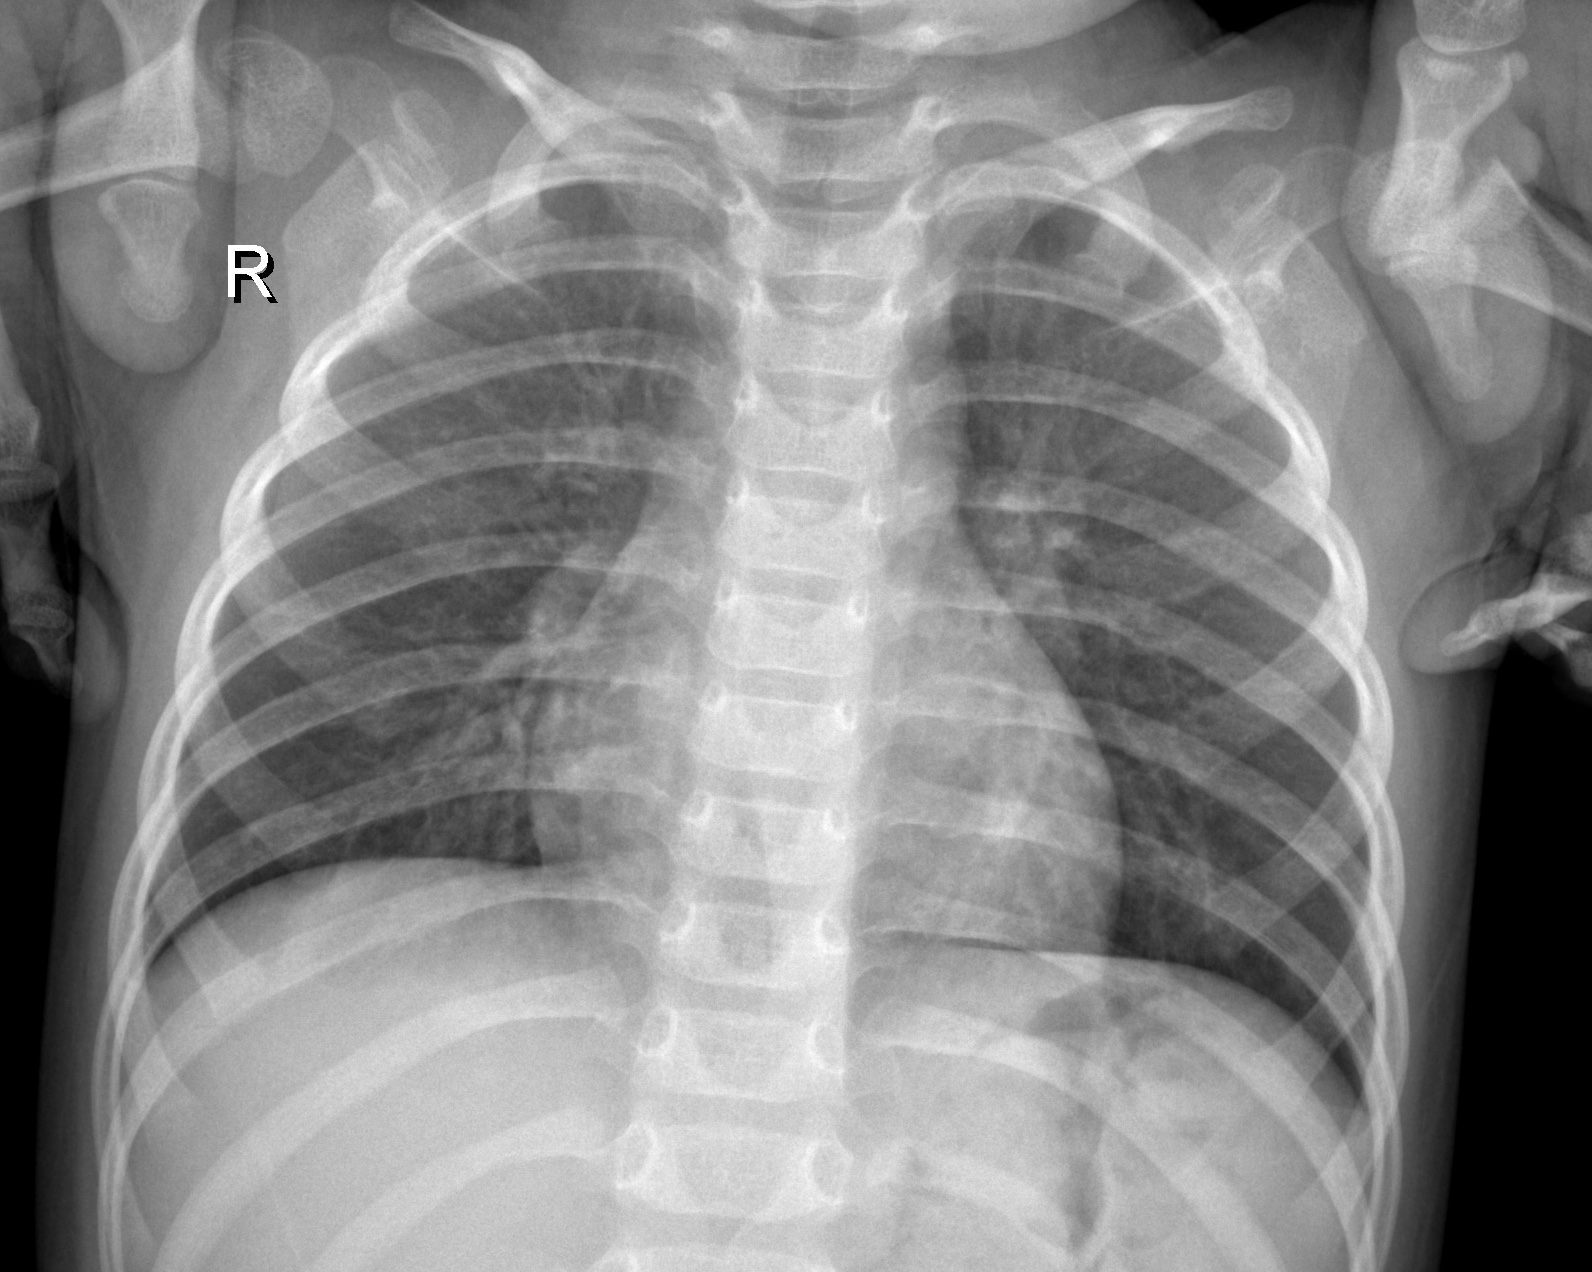

In [5]:
PIL.Image.open(str(normal_vis[-1]))

In [6]:
batch_size = 100
image_width = 128
image_height = 128
random_state = 100

In [7]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [8]:
class_names = train_data.class_names
class_names

['NORMAL', 'PNEUMONIA']

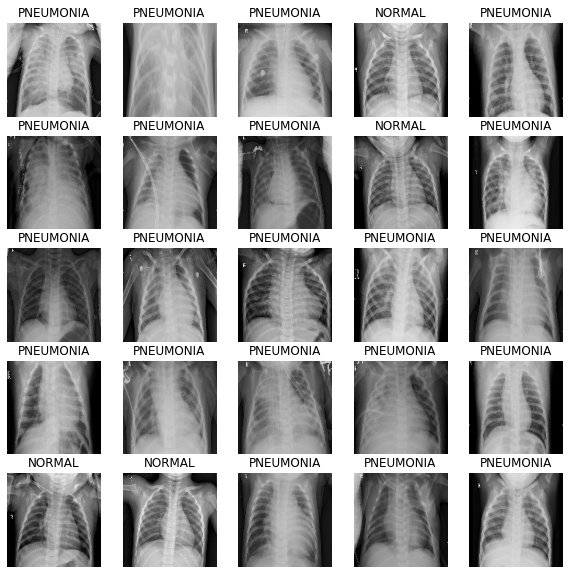

In [9]:
plt.figure(figsize = (10, 10))
for images, labels in train_data.take(1):
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis(False)

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)]
)

In [11]:
data_preprocessing_resnet = tf.keras.applications.resnet.preprocess_input

base_model_resnet = tf.keras.applications.resnet.ResNet50(
    input_shape = (image_height, image_width, 3),
    include_top = False,
    weights = "imagenet"
)

94781440/94765736 [==============================] - 0s 0us/step


In [12]:
base_model_resnet.trainable = False

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation = "sigmoid")

In [14]:
inputs = tf.keras.Input((128, 128, 3))
x = data_augmentation(inputs)
x = data_preprocessing_resnet(x)
x = base_model_resnet(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

In [15]:
model_resnet = tf.keras.Model(inputs = inputs, outputs = outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05)

In [16]:
model_resnet.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5)


In [18]:
history_resnet = model_resnet.fit(train_data, validation_data = val_data, batch_size = 100, epochs = 10, callbacks=[early_stopping])


Epoch 1/10
53/53 [==============================] - 35s 425ms/step - loss: 2.6766 - accuracy: 0.8520 - val_loss: 1.3151 - val_accuracy: 0.8125
Epoch 2/10
53/53 [==============================] - 17s 267ms/step - loss: 0.5205 - accuracy: 0.9371 - val_loss: 0.0364 - val_accuracy: 1.0000
Epoch 3/10
53/53 [==============================] - 16s 256ms/step - loss: 0.4046 - accuracy: 0.9363 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 4/10
53/53 [==============================] - 16s 261ms/step - loss: 0.3682 - accuracy: 0.9365 - val_loss: 2.3573 - val_accuracy: 0.6250
Epoch 5/10
53/53 [==============================] - 16s 257ms/step - loss: 0.4950 - accuracy: 0.9266 - val_loss: 0.9714 - val_accuracy: 0.8750
Epoch 6/10
53/53 [==============================] - 16s 264ms/step - loss: 0.5283 - accuracy: 0.9363 - val_loss: 0.3634 - val_accuracy: 0.8750
Epoch 7/10
53/53 [==============================] - 16s 255ms/step - loss: 0.5974 - accuracy: 0.9300 - val_loss: 0.7969 - val_accuracy: 0.8125

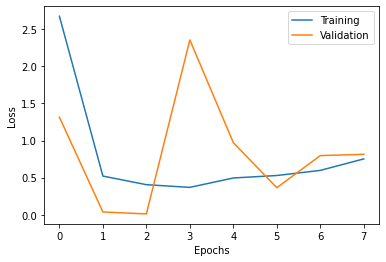

In [19]:
#PLotting the graph between epochs loss for loss and val_loss

sb.lineplot(x = range(len(history_resnet.history["loss"])), y = history_resnet.history["loss"], label = "Training")
sb.lineplot(x = range(len(history_resnet.history["loss"])), y = history_resnet.history["val_loss"], label = "Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

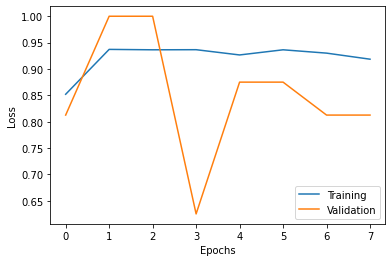

In [20]:
#PLotting the graph between epochs loss for accuracy and val_accuracy

sb.lineplot(x = range(len(history_resnet.history["loss"])), y = history_resnet.history["accuracy"], label = "Training")
sb.lineplot(x = range(len(history_resnet.history["loss"])), y = history_resnet.history["val_accuracy"], label = "Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc = "lower right")

In [21]:
# Evaluate the model
result_resnet = model_resnet.evaluate(test_data)
print(f"Loss: {result_resnet[0]}")
print(f"Accuracy: {result_resnet[1] * 100}")

7/7 [==============================] - 3s 81ms/step - loss: 1.7594 - accuracy: 0.8526
Loss: 1.759433627128601
Accuracy: 85.25640964508057


In [22]:
model_resnet.save("my_model.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [23]:
import keras

In [24]:
keras.models.load_model('my_model.h5')